In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
from island_ga import IslandGGA  , EliteIslandGGA 
from chromosome import Chromosome 
import itertools

In [2]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [3]:
#  """Based on parameter setting adopted in Chen et al (2021) """
def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies

In [4]:
#split data
train = aapl[(aapl['Date'] <= date(2019,12,31))]
test = aapl[(aapl['Date'] > date(2019,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())
ga = IslandGGA(data=train_data,num_islands=5,strategies=strategies,evolve_strategy="multikuti")

In [5]:
ga.evolve()

Island 0 - Generation 0: Best fitness = 266.0034920930667
Island 1 - Generation 0: Best fitness = 273.0540596602103
Island 2 - Generation 0: Best fitness = 231.64855319319446
Island 3 - Generation 0: Best fitness = 238.8331678348439
Island 4 - Generation 0: Best fitness = 257.1005780493461
Island 0 - Generation 25: Best fitness = 116.27297380012496
Island 1 - Generation 25: Best fitness = 237.8351313374329
Island 2 - Generation 25: Best fitness = 101.52494374841004
Island 3 - Generation 25: Best fitness = 219.26450045645117
Island 4 - Generation 25: Best fitness = 96.39703253500096
Island 0 - Generation 50: Best fitness = 85.16684103879322
Island 1 - Generation 50: Best fitness = 108.12185126719285
Island 2 - Generation 50: Best fitness = 202.862602958929
Island 3 - Generation 50: Best fitness = 87.99279413793634
Island 4 - Generation 50: Best fitness = 151.36075563265607
Island 0 - Generation 75: Best fitness = 213.36306336395432
Island 1 - Generation 75: Best fitness = 100.8392999923

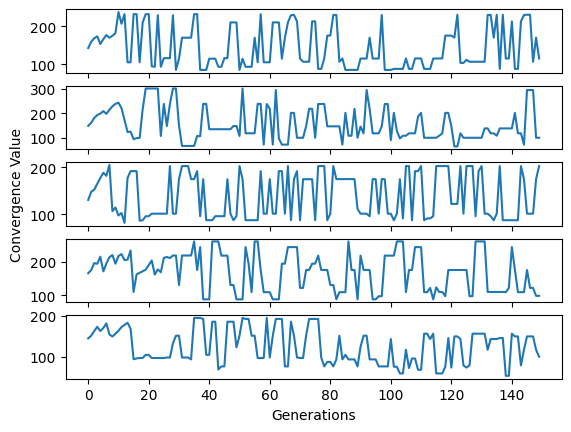

In [6]:
import matplotlib.pyplot as plt

global_list =ga.convergence_values
if all(isinstance(item, list) for item in global_list):
    num_variables = len(global_list[0])
    num_timesteps = len(global_list)

    # Create subplots for each variable
    fig, axes = plt.subplots(num_variables, 1, sharex=True)

    # Plot each variable on its corresponding subplot
    for var_index in range(num_variables):
        var_data = [global_list[i][var_index] for i in range(num_timesteps)]
        axes[var_index].plot(var_data)

    # Add x and y labels to the last subplot
    axes[num_variables-1].set_xlabel('Generations')
    axes[num_variables//2].set_ylabel('Convergence Value')

    # Display the plot
    plt.show()
else:
    cols = ["Convergence"]
    df = pd.DataFrame(np.column_stack([ga.convergence_values]), columns=cols)
    df.plot()



In [40]:
sl_part = [1,1,1,1]
tp_part = [1,1,0,1,1,1,0,1]
tp_part = [1,0,0,1]
max_sl = sum([np.power(2,i)*1 for i in range(len(sl_part))])
max_tp = sum([np.power(2,i)*1 for i in range(len(tp_part))])
sl_part.reverse()
tp_part.reverse()
sl  = sum([np.power(2,i)*sl_part[i] for i in range(len(sl_part))])
tp  = sum([np.power(2,i)*tp_part[i] for i in range(len(tp_part))])
sl = stop_loss/max_sl * sl
tp = take_profit/max_tp * tp
print(tp)

0.09


In [ ]:
ring = []
master = []
multi = []
gga = []
for i in range(80):
    islandgga.evolve_island_ring()
    best  = islandgga.globalBest
    ring.append(best)
    islandgga.evolve_master_slave()
    best  = islandgga.globalBest
    master.append(best)
    islandgga.evolve_island_multikuti()
    best  = islandgga.globalBest
    multi.append(best)
    islandgga.evolve_gga()
    best  = islandgga.globalBest
    gga.append(best)
    print("ITERATION: {} DONE".format(i+1))
    print("========================")
p_ring = []
p_master = []
p_multi = []
p_gga = []
for i in range(80):
    p_ring.append(ring[i].getProfit(test_data,allocated_capital))
    p_master.append(master[i].getProfit(test_data,allocated_capital))
    p_multi.append(multi[i].getProfit(test_data,allocated_capital))
    p_gga.append(gga[i].getProfit(test_data,allocated_capital))
# multiple lines with legend
cols = ["Ring Topology","Master-Slave","Multikuti","GGA"]
df = pd.DataFrame({'Algorithm':cols, 'Total Return':[np.mean(p_ring),np.mean(p_master),np.mean(p_gga),np.mean(p_multi)]})
ax = df.plot.bar(x='Algorithm', y='Total Return', rot=0)

In [ ]:
def getProfit(self,ts_data,allocated_capital):
        weights = self.getWeights()
        L = sum([i for i in self.weight_part if i == 1])
        for i in weights:
            try:
                weights[i]= round(len(weights[i])/L,2)
            except ZeroDivisionError:
                weights[i] = 0
        if all(value == 0 for value in weights.values()):
            for i in weights:
                percent = round(1/(self.K+1),2)
                weights[i] = percent
        total = 0
        for i in range(len(self.group_part)):
            for j in self.group_part[i]:
                avg_return = ts_data[j].mean()
                total += avg_return*weights[i+1]*allocated_capital
        return total
def getCorrelation(self,ts_data):
        weights = self.getWeights()
        w = self.weight_part
        L = sum([i for i in w if i == 1])
        for i in weights:
            try:
                weights[i]= round(len(weights[i])/L,2)
            except ZeroDivisionError:
                weights[i] = 0

        if all(value == 0 for value in weights.values()):
            for i in weights:
                percent = round(1/(self.K+1),2)
                weights[i] = percent
        weights_df = pd.DataFrame([weights])
        weights_df = weights_df.drop(0,axis=1)
        total = 0
        combs = list(itertools.product(*self.group_part))
        for ts in  combs:
            tsp = ts_data[list(ts)].corr()
            tsp_var = np.linalg.multi_dot([weights_df.to_numpy(),tsp.to_numpy(),weights_df.to_numpy().T])
            total += tsp_var
        try:
            total = total.item(0)
        except:
            total = total
        return total

In [ ]:

p_ring = []
p_master = []
p_multi = []
p_gga = []
for i in range(80):
    p_ring.append(getProfit(ring[i],test_data,allocated_capital))
    p_master.append(getProfit(master[i],test_data,allocated_capital))
    p_multi.append(getProfit(multi[i],test_data,allocated_capital))
    p_gga.append(getProfit(gga[i],test_data,allocated_capital))
cols = ["Ring Topology","Master-Slave","Multikuti",'GGA']
cols_1= ["Ring Topology","Master-Slave","Multikuti"]
df = pd.DataFrame(np.column_stack([p_ring,p_master,p_multi,p_gga]), 
                               columns=cols)


df.describe()

#df_1 =df_1.dropna(axis = 0)
#df.plot(kind='box')

In [ ]:
p_ring = []
p_master = []
p_multi = []
p_gga = []
for i in range(80):
    p_ring.append(getCorrelation(ring[i],ring[i].strategy_performance(test_data)))
    p_master.append(getCorrelation(master[i],master[i].strategy_performance(test_data)))
    p_multi.append(getCorrelation(multi[i],multi[i].strategy_performance(test_data)))
    p_gga.append(getCorrelation(gga[i],gga[i].strategy_performance(test_data)))
cols = ["Ring Topology","Master-Slave","Multikuti",'GGA']
cols_1= ["Ring Topology","Master-Slave","Multikuti"]
df = pd.DataFrame(np.column_stack([p_ring,p_master,p_multi,p_gga]), 
                               columns=cols)


print(df.describe())

#df_1 =df_1.dropna(axis = 0)
#df.plot(kind='box')

In [ ]:
p_ring = []
p_master = []
p_multi = []
p_gga = []
for i in range(80):
    ring[i].calculate_chromosome_fitness(test_data,allocated_capital)
    p_ring.append(ring[i].fitness_value)
    master[i].calculate_chromosome_fitness(test_data,allocated_capital)
    p_master.append(master[i].fitness_value)
    multi[i].calculate_chromosome_fitness(test_data,allocated_capital)
    p_multi.append(multi[i].fitness_value)
    gga[i].calculate_chromosome_fitness(test_data,allocated_capital)
    p_gga.append(gga[i].fitness_value)
cols = ["Ring Topology","Master-Slave","Multikuti",'GGA']
#cols_1 = ["Ring Topology","Master-Slave","Multikuti"]
df = pd.DataFrame(np.column_stack([p_ring,p_master,p_multi,p_gga]), 
                               columns=cols)
#df_1 = df[cols_1]

#df_1 = df_1[df[cols_1] < 100000]
#print(df_1.isna().sum())
#df_1 =df_1.dropna(axis = 0)
df.describe()
#df.plot(kind='box')